In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, sys
from pathlib import Path
project_root = Path().absolute().parent
sys.path.append(str(project_root))

import src.utils as utils
import src.services.analysis_service as analysis_service
import src.services.visualization_service as visualization_service

from src.config import DATA_DIR


2024-12-21 19:15:51 | INFO     | src.config:<module>:10 | Загружена конфигурация из .env


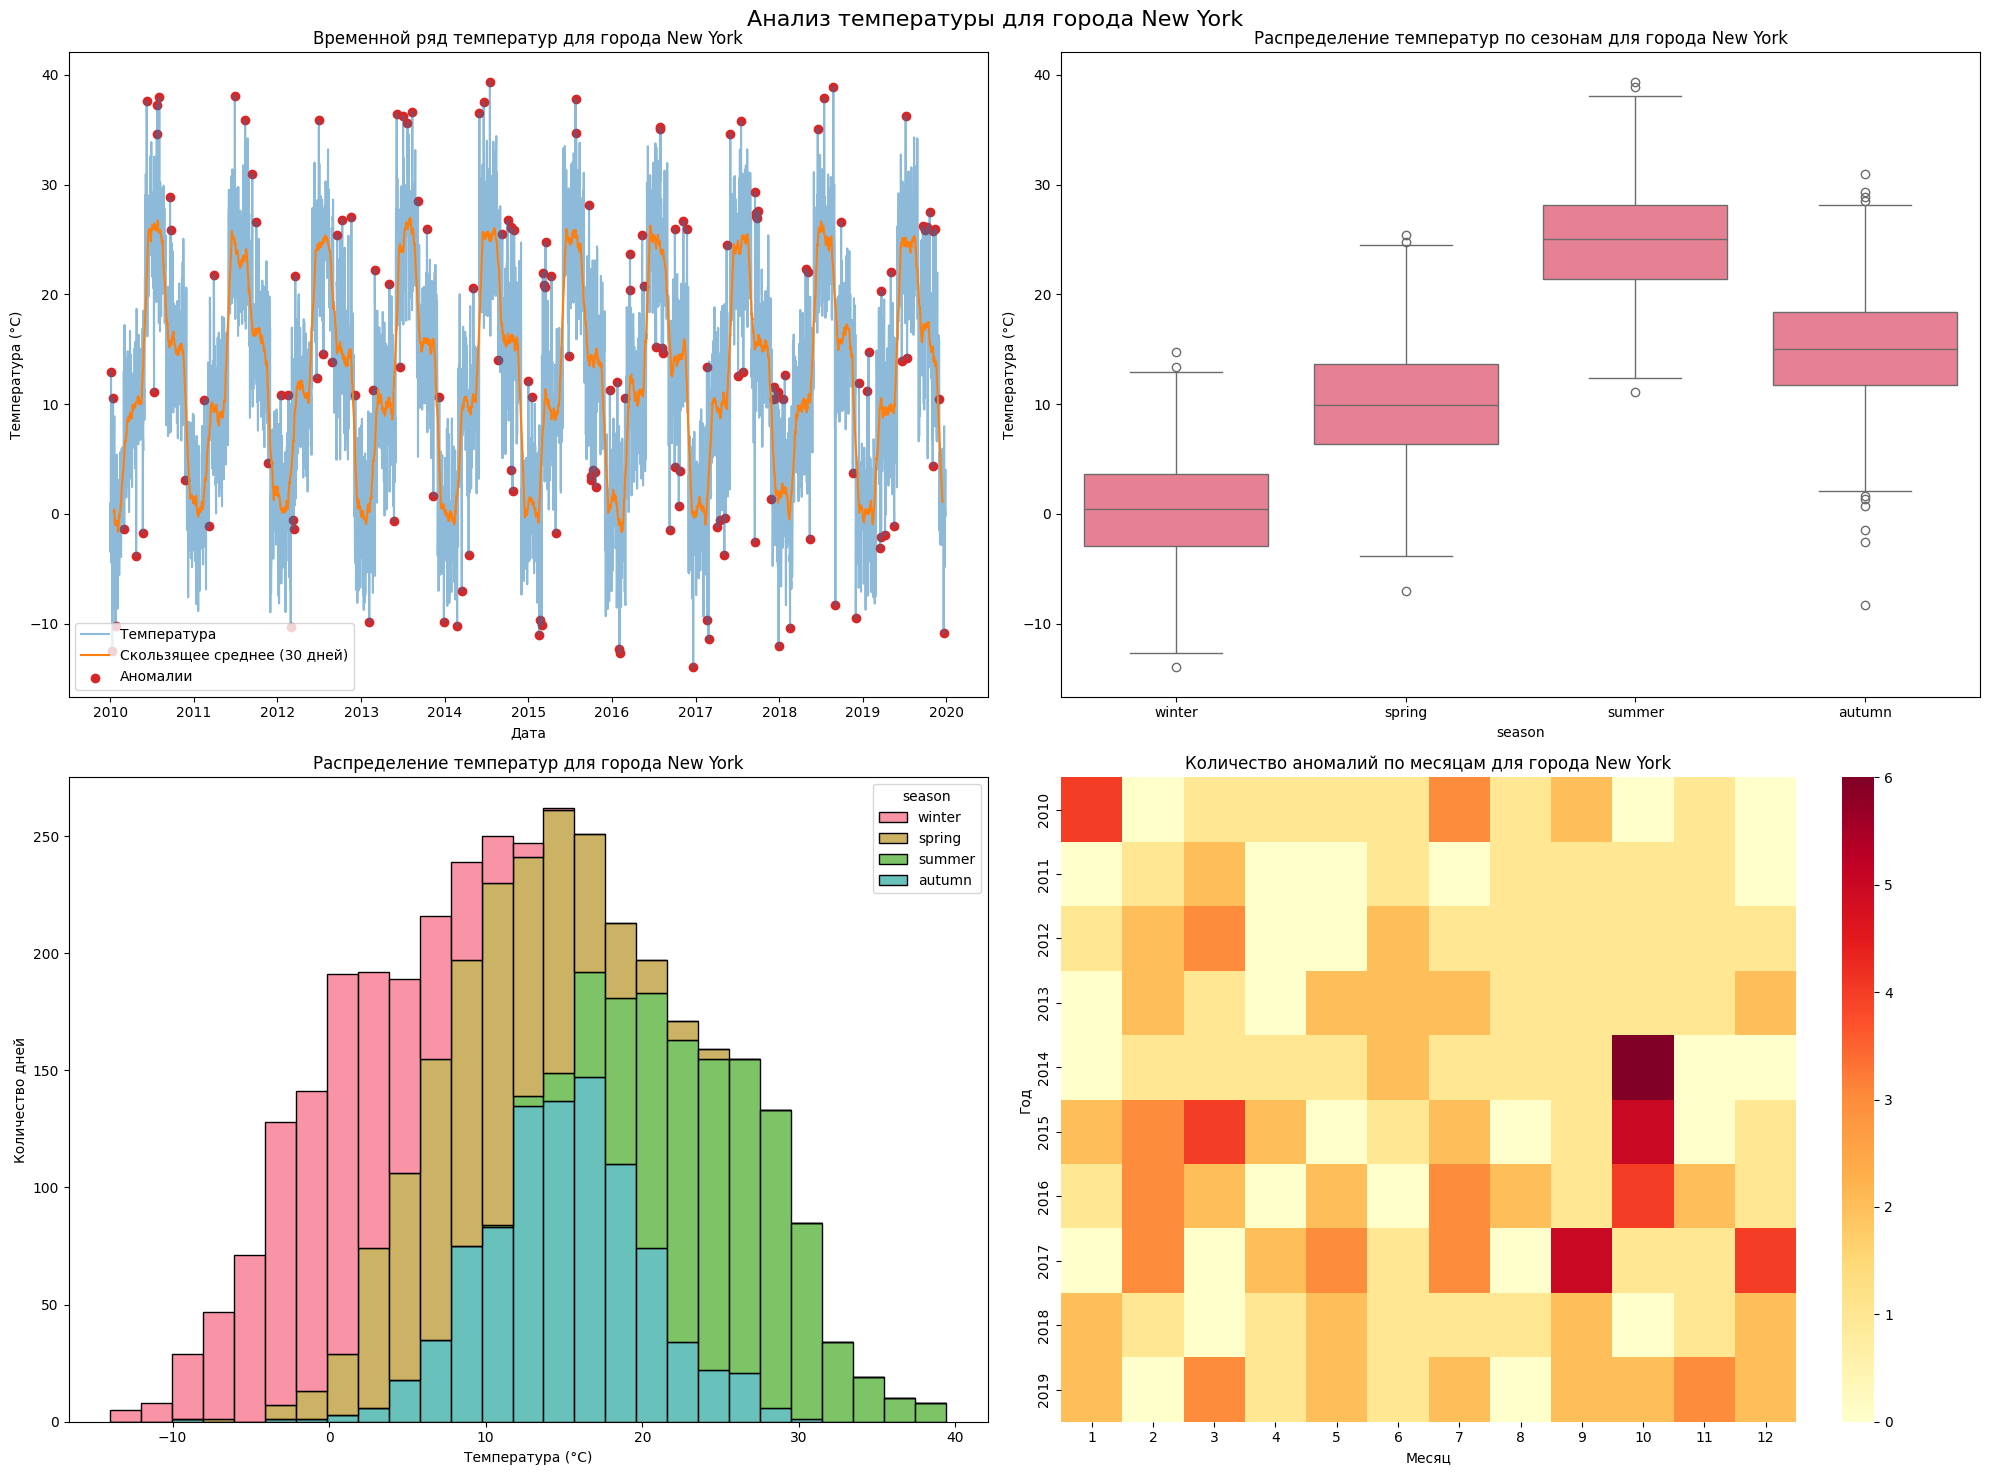


Статистика по сезонам для города New York:
       temperature      
              mean   std
season                  
autumn       15.05  5.17
spring        9.90  5.11
summer       24.89  4.85
winter        0.40  4.89

Общее количество аномалий: 166

Процент аномальных дней по сезонам:
        sum  count  percentage
season                        
autumn   49    910        5.38
spring   38    920        4.13
summer   38    920        4.13
winter   41    900        4.56


In [2]:
# Настройки для графиков
plt.style.use('seaborn-v0_8-dark-palette')
sns.set_palette("husl")

# Загружаем данные
df = pd.read_csv(DATA_DIR / 'temperature_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Анализ температурных данных для всех городов
results = await analysis_service.AnalysisService.analyze_all_cities_temperature(df)

cities = df['city'].unique()

# Выбираем город для детального анализа
city = cities[0]  # например, первый город
city_results = results[city]
city_data = city_results.data
seasonal_stats = city_results.seasonal_stats

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle(f'Анализ температуры для города {city}', fontsize=16)

viz_service = visualization_service.VisualizationService()
viz_service.setup_style()

# Встраиваем графики в существующие оси
viz_service.plot_temperature_time_series(
    city_data,
    city,
    ax=axes[0, 0]
)

viz_service.plot_seasonal_boxplot(
    city_data,
    city,
    ax=axes[0, 1]
)

viz_service.plot_temperature_distribution(
    city_data,
    city,
    ax=axes[1, 0]
)

viz_service.plot_anomalies_heatmap(
    city_data,
    city,
    ax=axes[1, 1]
)

plt.tight_layout()
plt.show()


# Выводим статистику
print(f"\nСтатистика по сезонам для города {city}:")
print(seasonal_stats)

print(f"\nОбщее количество аномалий: {city_data['is_anomaly'].sum()}")
print("\nПроцент аномальных дней по сезонам:")
seasonal_anomalies = city_data.groupby('season')['is_anomaly'].agg(['sum', 'count'])
seasonal_anomalies['percentage'] = (seasonal_anomalies['sum'] / seasonal_anomalies['count'] * 100).round(2)
print(seasonal_anomalies)

# Исследование распараллеливания анализа

In [6]:
# последоватльный анализ
start_time = time.time()
results = {city: utils.analyze_temperature_data(df, city) for city in cities}
end_time = time.time()
print(f"Время выполнения последовательного анализа: {end_time - start_time:.2f} секунд")

Время выполнения последовательного анализа: 0.10 секунд


In [7]:
# параллельный анализ
start_time = time.time()
results, execution_time = utils.run_parallel_analysis(df)
end_time = time.time()
print(f"Время выполнения параллельного анализа: {end_time - start_time:.2f} секунд (выполнено в ноутбуке) / {execution_time=}/")


Время выполнения параллельного анализа: 0.92 секунд (выполнено в ноутбуке) / execution_time=0.7991137504577637/


Вывод:
- на таком количестве данных параллельный анализ не дает выигрыша в скорости
